In [89]:
#LIBRARIES
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st
from sklearn.model_selection import train_test_split,KFold,StratifiedKFold,GridSearchCV,RandomizedSearchCV,cross_val_score
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier,AdaBoostClassifier,GradientBoostingClassifier,RandomForestRegressor,BaggingRegressor,AdaBoostRegressor,GradientBoostingRegressor
from sklearn.linear_model import LinearRegression,LogisticRegression,Lasso, Ridge
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier,KNeighborsRegressor
import sklearn.metrics as metrics
from sklearn.metrics import r2_score,roc_auc_score,classification_report,mean_squared_error,accuracy_score,confusion_matrix,precision_score,recall_score
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from sklearn import svm
from sklearn.ensemble import GradientBoostingClassifier
import warnings
warnings.filterwarnings('ignore')
import sklearn.ensemble as ensemble
import sklearn.metrics as metrics
from lightgbm import LGBMClassifier
import xgboost
from catboost import CatBoostClassifier
from sklearn.linear_model import RidgeClassifier
import vaex
%matplotlib inline

In [90]:
%%time
master=pd.read_csv('D:/R/CardioVascularDisease/cardio_train.csv',sep=';')
master.head()

Wall time: 65.8 ms


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,988,22469,1,155,69.0,130,80,2,2,0,0,1,0
1,989,14648,1,163,71.0,110,70,1,1,0,0,1,1
2,990,21901,1,165,70.0,120,80,1,1,0,0,1,0
3,991,14549,2,165,85.0,120,80,1,1,1,1,1,0
4,992,23393,1,155,62.0,120,80,1,1,0,0,1,0


In [91]:
ds=master.dtypes[master.dtypes!='object'].index
print(ds)

Index(['id', 'age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo',
       'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio'],
      dtype='object')


In [92]:
master.isnull().sum()/len(master)*100

id             0.0
age            0.0
gender         0.0
height         0.0
weight         0.0
ap_hi          0.0
ap_lo          0.0
cholesterol    0.0
gluc           0.0
smoke          0.0
alco           0.0
active         0.0
cardio         0.0
dtype: float64

In [93]:
cat={'gender','cholesterol','gluc','smoke','alco','active'}
num={'age','height','weight','ap_hi','ap_lo'}

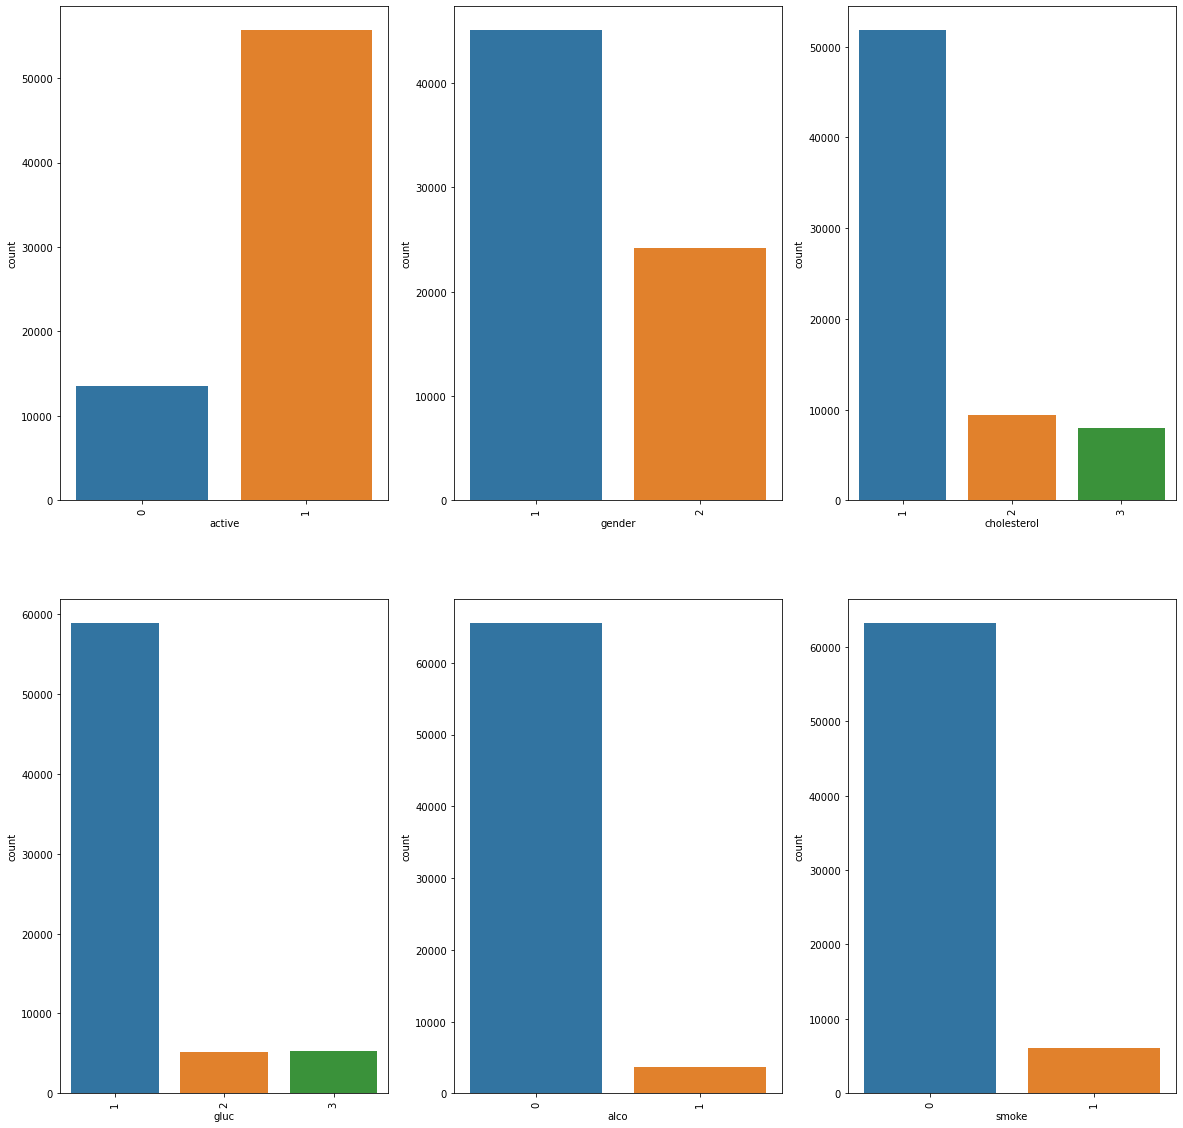

In [94]:
fig, ax=plt.subplots(2,3,figsize=(20,20))
for i,subplot in zip(cat,ax.flatten()):
    sns.countplot(master[i],ax=subplot)
    for label in subplot.get_xticklabels():
        label.set_rotation(90)

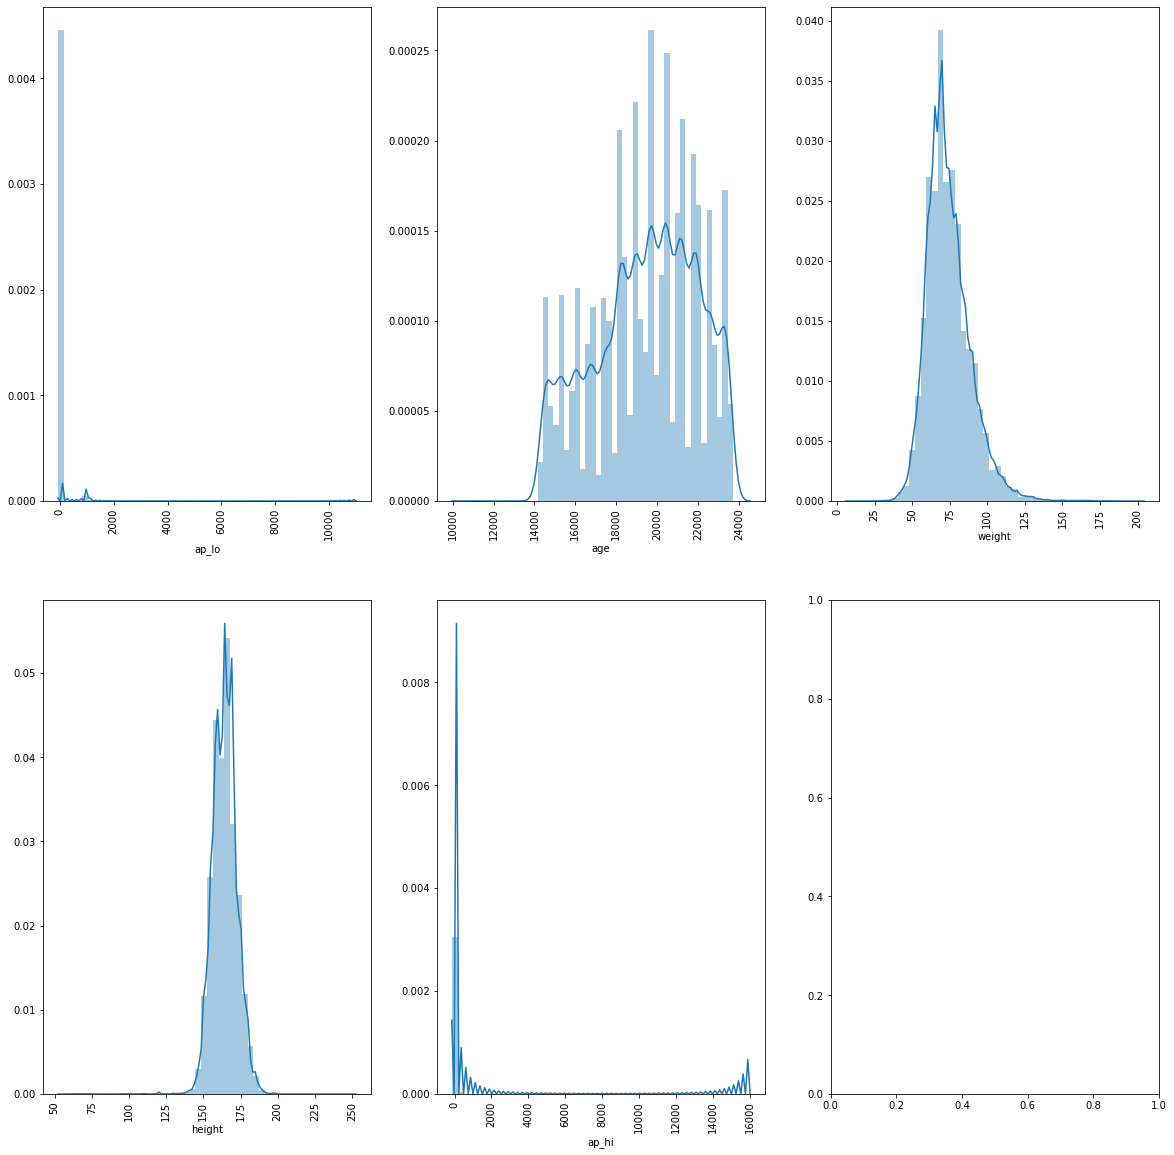

In [95]:
fig,ax=plt.subplots(2,3,figsize=(20,20))
for i,subplot in zip(num,ax.flatten()):
    sns.distplot(master[i],ax=subplot)
    for label in subplot.get_xticklabels():
        label.set_rotation(90)

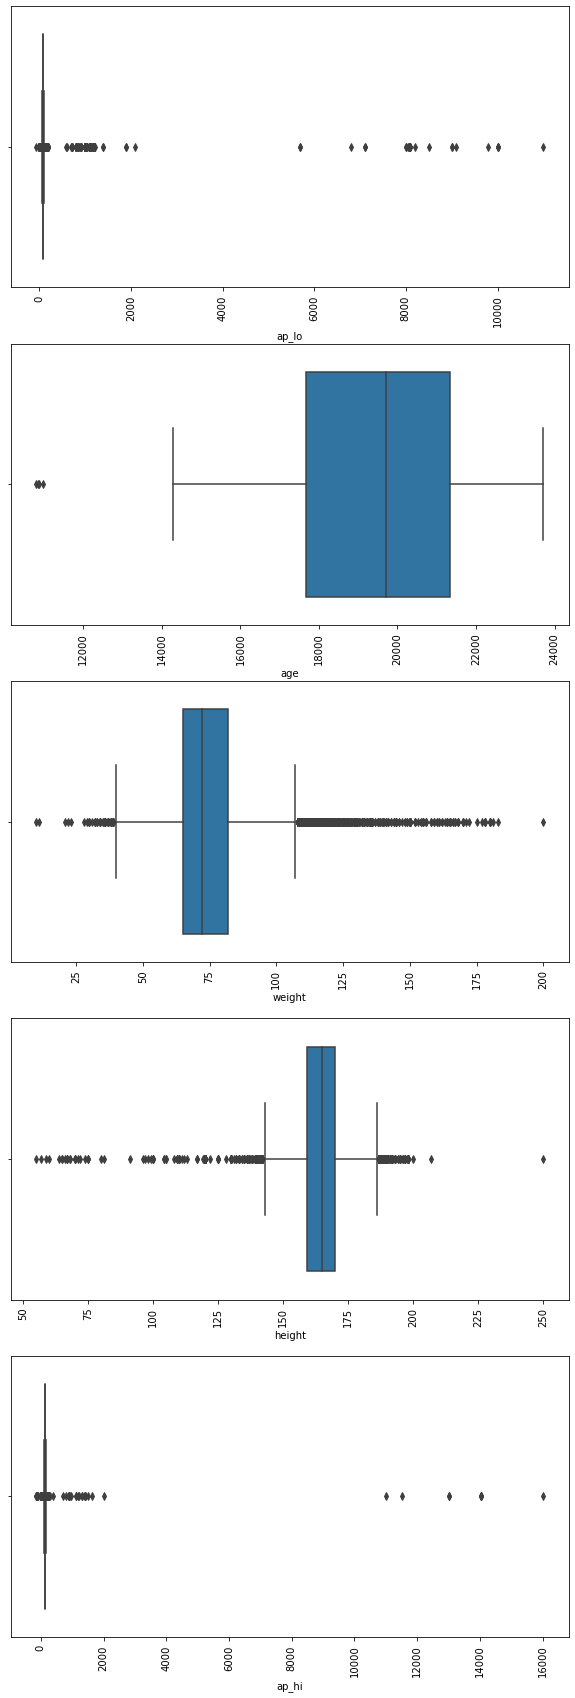

In [96]:
# VISUALISING BOXPLOT
fig, ax=plt.subplots(5,figsize=(10,30))
for variable,subplot in zip(num,ax.flatten()):
    sns.boxplot(master[variable], ax=subplot)
    for label in subplot.get_xticklabels():
        label.set_rotation(90)

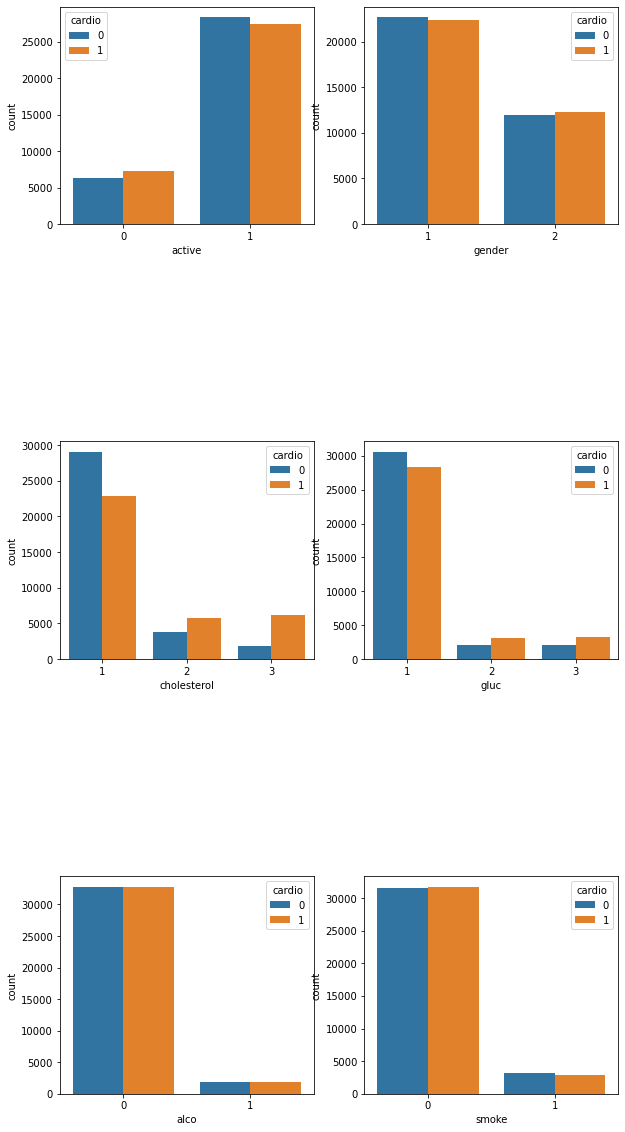

In [97]:
# Category vs Target
fig,axes = plt.subplots(3,2,figsize=(10,20))
for idx,cat_col in enumerate(cat):
    row,col = idx//2,idx%2
    sns.countplot(x=cat_col,data=master,hue='cardio',ax=axes[row,col])


plt.subplots_adjust(hspace=1)

In [98]:
#QUANTILE 1 TO 100#
def out(x):
    d=np.arange(0,1,0.01)
    ds=x.quantile(d)
    return ds




# FLORRING & CAPPING OF OUTLIERS #

In [99]:
master.age.loc[master.age > 23489.0]=23489.0
master.height.loc[master.height > 184.0]=184.0
master.weight.loc[master.weight > 117.0]=117.0
master.ap_lo.loc[master.ap_lo < 60.0]=60.0
master.ap_lo.loc[master.ap_lo > 110.0]=110.0
master.ap_hi.loc[master.ap_hi > 180.0]=180.0
master.ap_hi.loc[master.ap_hi < 90.0]=90.0

# FEATURE ENGINEERING#

In [100]:
#FEATURE ENGINEERING#
master['BMI']=(master.weight / master.height) / master.height
master['ap_st']=master.ap_hi - master.ap_lo

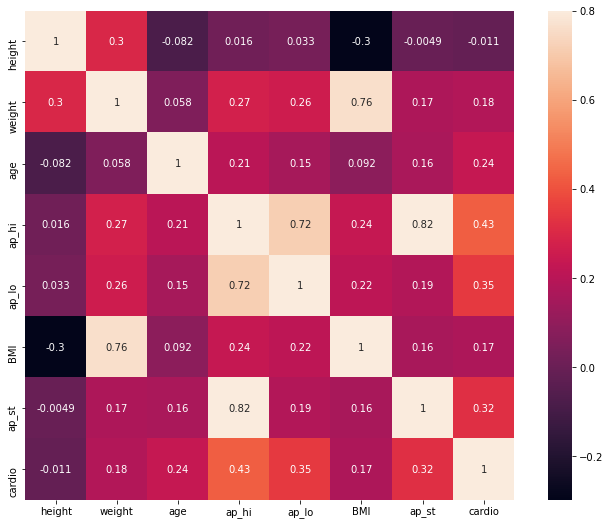

In [101]:
# CORRELATION MATIX#
contvars=master[['height','weight','age','ap_hi','ap_lo','BMI','ap_st','cardio']]
corrmat = contvars.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8,annot = True,square=True);

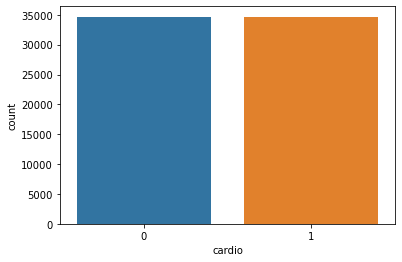

In [102]:
sns.countplot(master.cardio)

In [103]:
# MODEL BUILDING #
master=pd.get_dummies(master,columns=cat)
X = master.drop('cardio', axis = 1)
Y = master['cardio']

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

NameError: name 'x_train' is not defined

In [104]:
########SPLITTING#####
x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.2)


In [105]:
import sklearn.ensemble as ensemble
from catboost import CatBoostClassifier

lr = LogisticRegression()
rf=RandomForestClassifier()
adb=ensemble.AdaBoostClassifier()
bgc=ensemble.BaggingClassifier()
gnb = GaussianNB()
knn=KNeighborsClassifier()
dt = DecisionTreeClassifier()
bgcl_lr = BaggingClassifier(base_estimator=lr, random_state=0)
xgb=xgboost.XGBClassifier()
cat=CatBoostClassifier()

# ,ab_rf,ab_dt,ab_nb,ab_lr,bgcl_lr

models=[lr,rf,adb,bgc,gnb,knn,dt,bgcl_lr,xgb,cat]
sctr,scte,auc,ps,rs=[],[],[],[],[]
def ens(x_train,x_val, y_train, y_val):
    for model in models:
            model.fit(x_train, y_train)
            y_test_pred = model.predict(x_val)
            y_test_pred_new=model.predict_proba(x_val)
            y_test_pred_new=y_test_pred_new[:,1]
            train_score=model.score(x_train,y_train)
            test_score=model.score(x_val,y_val)
            p_score=metrics.precision_score(y_val,y_test_pred)
            r_score=metrics.recall_score(y_val,y_test_pred)
            
            ac=metrics.roc_auc_score(y_val,y_test_pred_new)
            
            sctr.append(train_score)
            scte.append(test_score)
            ps.append(p_score)
            rs.append(r_score)
            auc.append(ac)
    return sctr,scte,auc,ps,rs
ens(x_train,x_val, y_train, y_val)
# 'ab_rf','ab_dt','ab_nb','ab_lr','bgcl_lr'
ensemble=pd.DataFrame({'names':['Logistic Regression','Random Forest','Ada boost','Bagging',
                                'Naive-Bayes','KNN','Decistion Tree',
                                'bagged LR','XgBoost','CatBoost'],
                       'auc_score':auc,'training':sctr,'testing':scte,'precision':ps,'recall':rs})
ensemble=ensemble.sort_values(by='auc_score',ascending=False).reset_index(drop=True)
ensemble

Learning rate set to 0.052195
0:	learn: 0.6779566	total: 96ms	remaining: 1m 35s
1:	learn: 0.6643985	total: 121ms	remaining: 1m
2:	learn: 0.6521854	total: 143ms	remaining: 47.5s
3:	learn: 0.6412861	total: 167ms	remaining: 41.5s
4:	learn: 0.6315218	total: 198ms	remaining: 39.5s
5:	learn: 0.6227826	total: 236ms	remaining: 39.1s
6:	learn: 0.6148782	total: 260ms	remaining: 36.9s
7:	learn: 0.6080310	total: 286ms	remaining: 35.4s
8:	learn: 0.6020332	total: 306ms	remaining: 33.7s
9:	learn: 0.5963317	total: 331ms	remaining: 32.8s
10:	learn: 0.5912421	total: 359ms	remaining: 32.3s
11:	learn: 0.5867675	total: 381ms	remaining: 31.4s
12:	learn: 0.5826052	total: 430ms	remaining: 32.6s
13:	learn: 0.5789620	total: 468ms	remaining: 33s
14:	learn: 0.5759417	total: 496ms	remaining: 32.6s
15:	learn: 0.5734006	total: 528ms	remaining: 32.5s
16:	learn: 0.5706617	total: 558ms	remaining: 32.2s
17:	learn: 0.5681323	total: 584ms	remaining: 31.9s
18:	learn: 0.5658534	total: 615ms	remaining: 31.8s
19:	learn: 0.563

,names,auc_score,training,testing,precision,recall
0,XgBoost,0.803116,0.739015,0.734795,0.754309,0.695464
1,CatBoost,0.800792,0.762825,0.733208,0.754660,0.690118
2,Ada boost,0.795087,0.732828,0.729240,0.765900,0.659347
3,bagged LR,0.793824,0.728553,0.728807,0.757448,0.672205
4,Logistic Regression,0.793790,0.728481,0.729312,0.756805,0.674805
5,Random Forest,0.780258,1.000000,0.716687,0.728591,0.689541
6,Naive-Bayes,0.761802,0.687590,0.685593,0.733261,0.582202
7,Bagging,0.754294,0.981494,0.699012,0.725928,0.638255
8,KNN,0.738523,0.784614,0.692158,0.697280,0.677839
9,Decistion Tree,0.632348,1.000000,0.632350,0.632242,0.630598


In [ ]:
cs=[x for x in df.columns if len(df[x].valu_counts() > 10)]